# Mod 4 Project - WV Metro Areas Notebook

This notebook is used to do some side analysis of the other metro areas of West Virginia.

# Import Libaries

In [123]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools

import warnings
warnings.filterwarnings('ignore')

## Import My Functions from flatiron_time_series.py

In [124]:
from flatiron_time_series import get_SARIMA_parameters, run_SARIMAX
from flatiron_time_series import plot_prediction, get_forecast, plot_forecasts
from flatiron_time_series import pacf_plot, acf_plot

# Step 1: Load the Data/Filtering for Chosen Zipcodes

I am analyzing data for the WV Panhandle area - These 24 zipcodes are found in the Hagerstown and Winchester metro areas.

In [125]:
data = pd.read_csv('zillow_data.csv')
data = data[(data.State=='WV') ]
print(data.shape)
data.head()

(72, 272)


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
967,69060,26554,Fairmont,WV,Fairmont,Marion,968,49700.0,49700.0,49900.0,...,109400,110000,110400,111500,113100,114900,116100,117000,117900,118800
989,69040,26505,Morgantown,WV,Morgantown,Monongalia,990,95100.0,95200.0,95300.0,...,183500,183900,184300,184900,185700,186400,186900,186900,186000,185000
2081,69043,26508,Brookhaven,WV,Morgantown,Monongalia,2082,83600.0,83900.0,84300.0,...,219900,220300,220600,220700,221300,222200,223000,223600,222700,221000
2399,68756,25801,Beckley,WV,Beckley,Raleigh,2400,44600.0,44600.0,44700.0,...,74900,75000,75100,74600,73100,72400,72500,73100,74800,76600
3012,68878,26101,Parkersburg,WV,Parkersburg,Wood,3013,58400.0,58300.0,58200.0,...,74500,74700,74900,75000,75200,75200,74900,74900,75200,75400


In [126]:
data.isna().sum().sum()

1351

In [127]:
data.Metro.value_counts()

Charleston     18
Huntington     13
Parkersburg     8
Beckley         6
Washington      6
Hagerstown      6
Fairmont        6
Morgantown      4
Weirton         4
Name: Metro, dtype: int64

In [128]:
metro_zipcodes = {}
for metro in data.Metro.unique():
    metro_zipcodes[metro] = list(data[data.Metro==metro]['RegionName'])
metro_zipcodes.pop(np.nan);

In [129]:
metro_zipcodes.keys()

dict_keys(['Fairmont', 'Morgantown', 'Beckley', 'Parkersburg', 'Huntington', 'Charleston', 'Weirton', 'Hagerstown', 'Washington'])

# Step 2: Data Preprocessing - Reshape to Wide Format

In [130]:
def get_datetimes(df,start_col=1):
    return pd.to_datetime(df.columns.values[start_col:], format='%Y-%m')

In [131]:
WV_df = pd.DataFrame()
WV_df['Month'] = get_datetimes(data,7)

In [132]:
for key in metro_zipcodes.keys():
    zipcodes = metro_zipcodes[key]
    metro_df = data[data.RegionName.isin(zipcodes)].iloc[:,7:]
    row = metro_df.median()
    WV_df[key] = row.values
WV_df.set_index('Month',inplace=True)

In [133]:
WV_df['Statewide'] = WV_df.mean(axis=1)

In [134]:
print(WV_df.shape)
WV_df.head()

(265, 10)


,Fairmont,Morgantown,Beckley,Parkersburg,Huntington,Charleston,Weirton,Hagerstown,Washington,Statewide
Month,,,,,,,,,,
1996-04-01,32300.0,72150.0,56050.0,70700.0,57100.0,56700.0,NaN,103250.0,106000.0,69281.25
1996-05-01,32550.0,72400.0,56450.0,70700.0,57000.0,56850.0,NaN,103400.0,105800.0,69393.75
1996-06-01,32700.0,72700.0,56850.0,70750.0,57100.0,57000.0,NaN,103600.0,105750.0,69556.25
1996-07-01,32950.0,73050.0,57200.0,70800.0,57100.0,57100.0,NaN,103900.0,105600.0,69712.50
1996-08-01,33200.0,73450.0,57550.0,70800.0,57200.0,57250.0,NaN,104250.0,105600.0,69912.50


# Step 3: EDA and Visualization

In [146]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [136]:
plt.gcf().autofmt_xdate()

<Figure size 432x288 with 0 Axes>

Text(0, 0.5, '$')

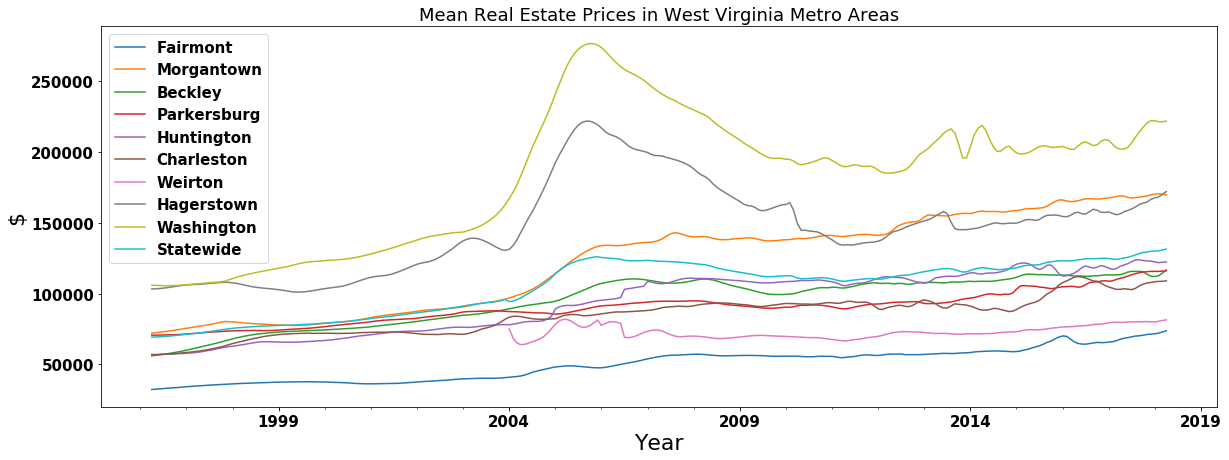

In [147]:
WV_df.plot(figsize=(20,7),legend=True)
plt.title("Mean Real Estate Prices in West Virginia Metro Areas");
plt.xlabel("Year",{'size':22})
plt.ylabel("$",{'size':22})

**The 2007/2008 housing bubble crash is very apparent in only a couple of the metro areas. These areas are both in the eastern panhandle. WV as a whole was mostly unaffected by the housing crash because it is a very poor state.**

### Seasonal Decomposition
Using statsmodels seasonal_decompose

In [77]:
decomposition = seasonal_decompose(np.log(WV_df.dropna()))

In [78]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

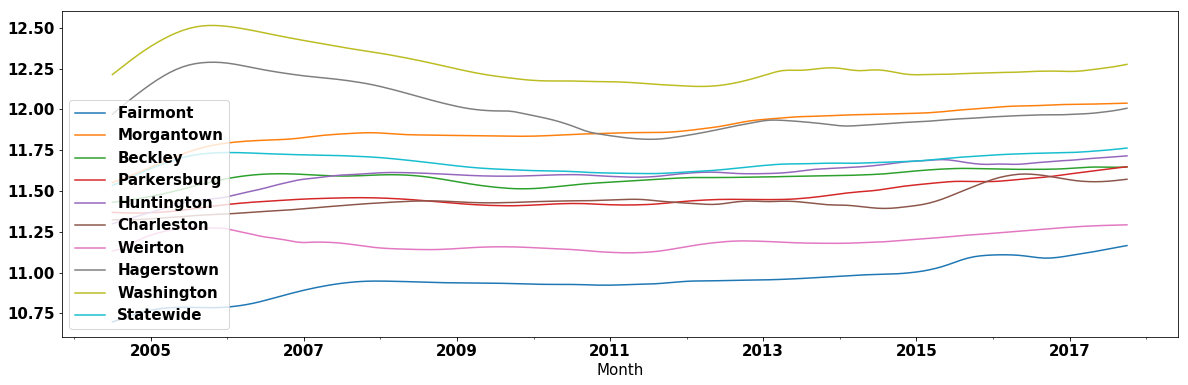

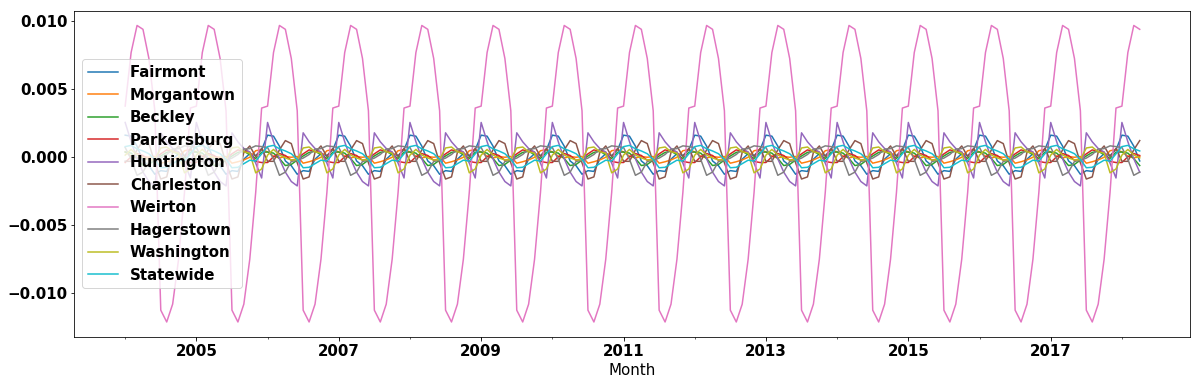

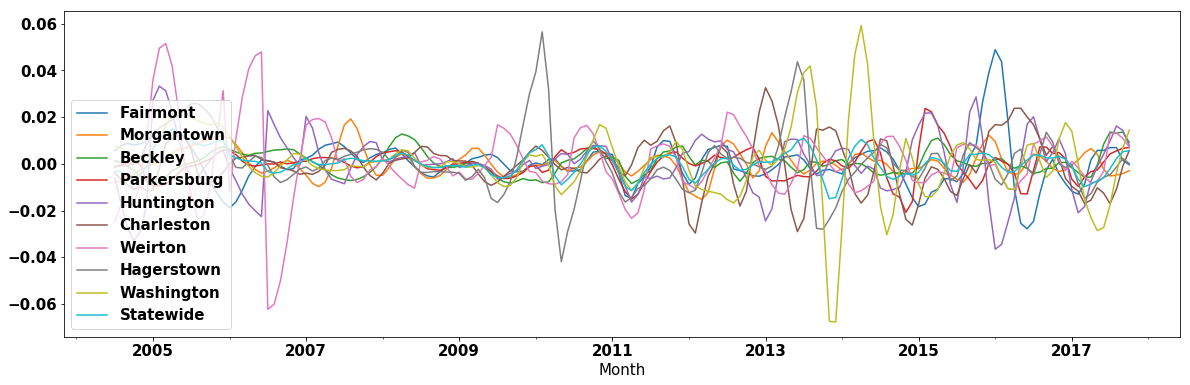

In [168]:
trend.plot(figsize=(20,6),legend=True)
seasonal.plot(figsize=(20,6),legend=True)
residual.plot(figsize=(20,6),legend=True)

# Step 4: ARIMA Modeling

#### Train/Test Split

In [82]:
split_date = '2017-08'
training, validation = WV_df[:split_date].Statewide, WV_df[split_date:].Statewide

### Testing different SARIMA Model parameters using Region average data

In [83]:
#ARIMA MODELING PARAMETERS
#Using s=12 because this is monthly data with yearly cycles
p = [0,1,2,3]
d = [0,1]
q = [0,1,2,3]

sp = [0,1,2]
sd = [0,1]
sq = [0,1,2]
s = [12]

In [84]:
results = get_SARIMA_parameters(training,p,d,q,sp,sd,sq,s)
results[0:5]

total combos =  576


[{'terms': (1, 1, 3),
  'seasonal terms': (2, 1, 2, 12),
  'AIC': 3096.3721442605347},
 {'terms': (1, 1, 3),
  'seasonal terms': (0, 1, 2, 12),
  'AIC': 3097.4877042699027},
 {'terms': (1, 1, 3),
  'seasonal terms': (1, 1, 2, 12),
  'AIC': 3097.9085550122495},
 {'terms': (2, 1, 3),
  'seasonal terms': (0, 1, 2, 12),
  'AIC': 3097.9696035436205},
 {'terms': (2, 1, 3),
  'seasonal terms': (1, 1, 2, 12),
  'AIC': 3100.718674548436}]

### Make model using results of parameter tests

In [86]:
ts = WV_df.Statewide

In [114]:
#pdq  = (1,1,3)
#pdqs = (0,1,2,12)

pdq   = (1,1,3)
pdqs  = (2,1,2,12)

model = run_SARIMAX(ts,pdq,pdqs)['model']
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          Statewide   No. Observations:                  265
Model:             SARIMAX(1, 1, 3)x(2, 1, 2, 12)   Log Likelihood               -1593.688
Date:                            Tue, 30 Jul 2019   AIC                           3205.376
Time:                                    15:32:06   BIC                           3236.081
Sample:                                04-01-1996   HQIC                          3217.770
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8969      0.058     15.410      0.000       0.783       1.011
ma.L1          0.1031      0.070      1.479      0.139      -0.034       0.240
ma.L2         -0.0672      0.100     -0.673      0.501      -0.263       0.128
ma.L3         -0.1072      0.076     -1.413      0.158      -0.256       0.042
ar.S.L12      -0.4628      0.207     -2.233      0.026      -0.869      -0.057
ar.S.L24       0.0482      0.030      1.600      0.110      -0.011       0.107
ma.S.L12      -0.6860      0.224     -3.061      0.002      -1.125      -0.247
ma.S.L24      -0.3141      0.225     -1.395      0.163      -0.755       0.127
sigma2       7.89e+04      2e-06   3.95e+10      0.000    7.89e+04    7.89e+04
===================================================================================
Ljung-Box (Q):                       46.96   Jarque-Bera (JB):              2612.78
Prob(Q):                              0.21   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                            -0.28
Prob(H) (two-sided):                  0.04   Kurtosis:                        19.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.56e+26. Standard errors may be unstable.
"""

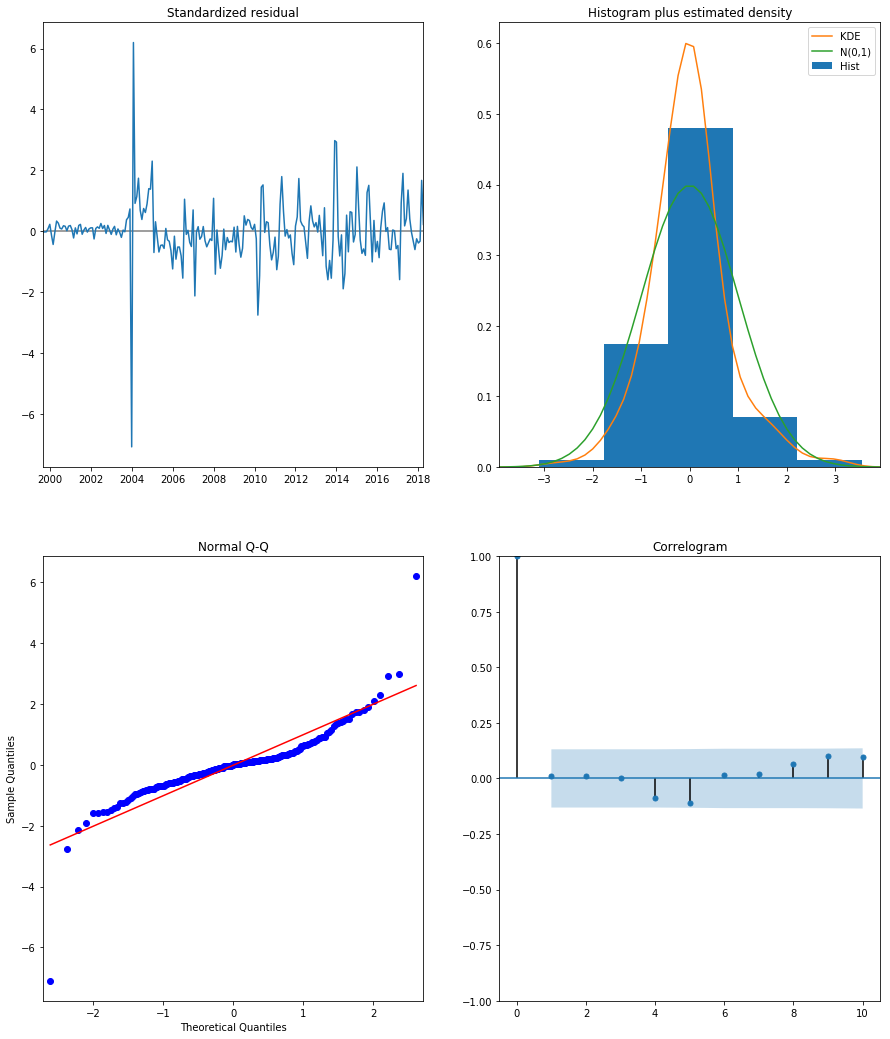

In [115]:
model.plot_diagnostics(figsize=(15,18));

## Making predictions using Model

### One-Step Ahead

RMSE:  268.22228531336197


268.22228531336197

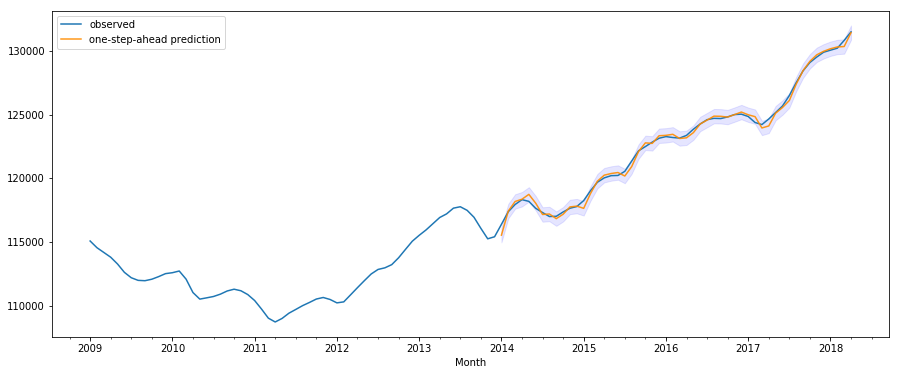

In [118]:
plot_prediction(ts['2009':],model,'2014', dynamic=False)

### Dynamic

RMSE:  2471.963702373609


2471.963702373609

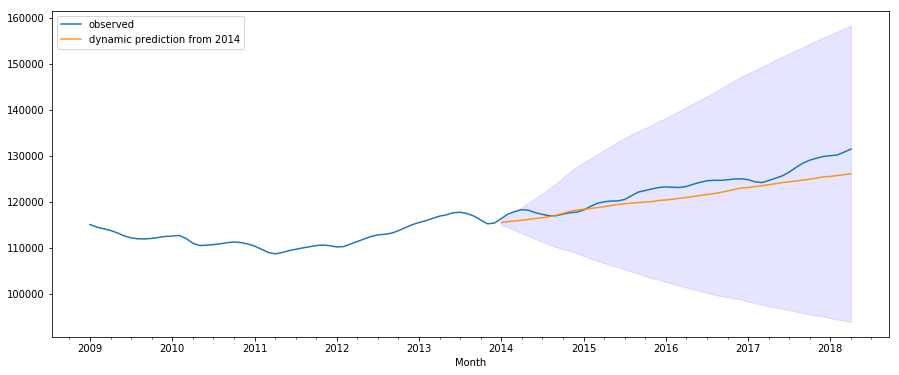

In [119]:
plot_prediction(ts['2009':],model,'2014',dynamic=True)

### Forecast

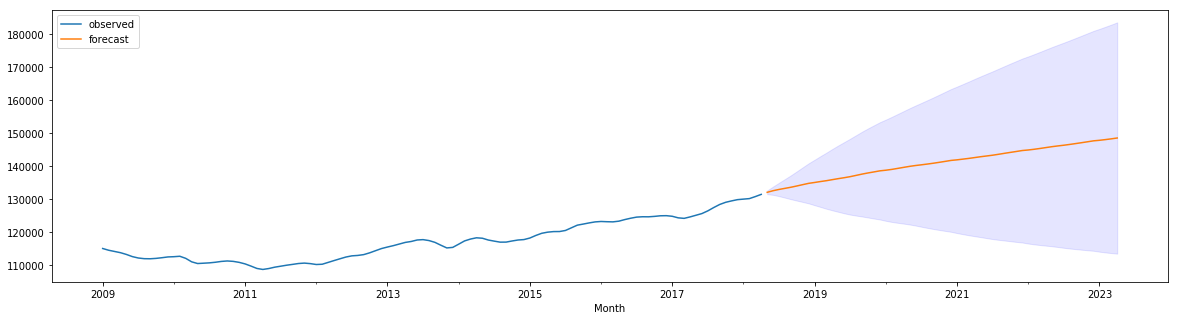

{'ROI_1yr': 0.034, 'ROI_5yr': 0.13}

In [120]:
get_forecast(ts['2009':],model,60,plot=True)

# Step 5: Apply Model & See Results

In [105]:
metro_results = []

steps = 60

for metro in WV_df.columns:
    regional_model = run_SARIMAX(WV_df[metro].dropna(),pdq,pdqs)['model']
    if regional_model==None:
        print("no model:",metro)
        continue
    result = get_forecast(WV_df[metro],regional_model,steps,plot=False)
    result['city'] = " "
    result['zipcode'] = metro
    result['model'] = regional_model
    metro_results.append(result)
metro_results = sorted(metro_results,key=lambda x: x['ROI_5yr'],reverse=True)

In [166]:
pd.DataFrame(metro_results)[0:5]

,ROI_1yr,ROI_5yr,city,model,zipcode
0,0.058,0.215,,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,Fairmont
1,0.030,0.202,,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,Washington
2,0.030,0.187,,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,Parkersburg
3,0.037,0.173,,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,Weirton
4,0.081,0.141,,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,Beckley


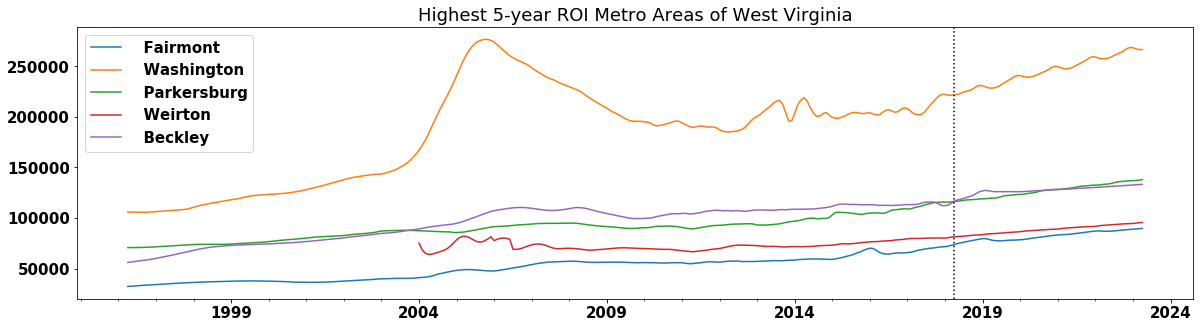

In [160]:
plot_forecasts(WV_df,sorted_results[0:5],steps=60,title='Highest 5-year ROI Metro Areas of West Virginia')

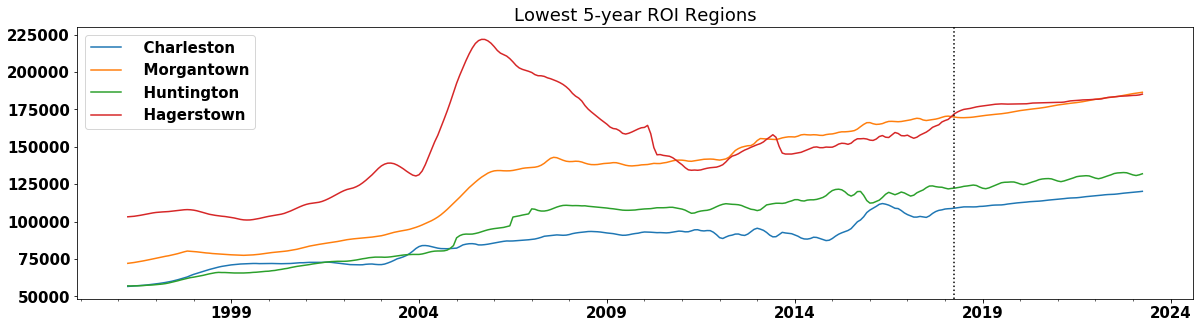

In [167]:
plot_forecasts(WV_df,sorted_results[-4:],steps=60,title='Lowest 5-year ROI Regions')